# Plotting our co-ordinates in the original data

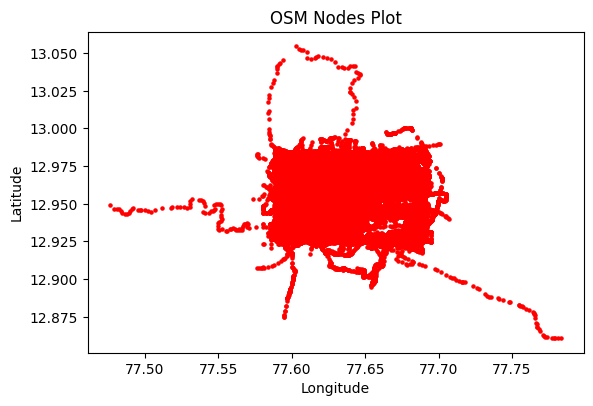

In [1]:
import xml.etree.ElementTree as ET
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

file_path = 'map'

tree = ET.parse(file_path)
root = tree.getroot()

nodes = []
for node in root.findall('node'):
    lat = float(node.get('lat'))
    lon = float(node.get('lon'))
    nodes.append((lon, lat))

gdf = gpd.GeoDataFrame(
    {'geometry': [Point(lon, lat) for lon, lat in nodes]},
    crs="EPSG:4326"
)
gdf.plot(marker='o', color='red', markersize=5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('OSM Nodes Plot')
plt.show()


# Group data from OSM by user, and then sort for each user by the timestamp

In [2]:
import xml.etree.ElementTree as ET
import pandas as pd

data = []

for node in root.findall('node'):
    user = node.get('user')
    if user:
        node_data = {
            'id': node.get('id'),
            'user': user,
            'uid': node.get('uid'),
            'lat': node.get('lat'),
            'lon': node.get('lon'),
            'timestamp': node.get('timestamp'),
            'changeset': node.get('changeset')
        }
        data.append(node_data)

df = pd.DataFrame(data)

df_sorted = df.sort_values(by=['user', 'timestamp'])

df_sorted.to_csv('eta_prediction_data.csv', index=False)

print("Data has been processed and saved successfully.")


Data has been processed and saved successfully.


# use two consecutive entries for a user, to get the segment of a road(initial longitude/latitude, final longitude/latitude) and the time for that segment(by subtracting timestamp).<br> 
# But make sure time_taken > 0, to clean data.  

In [23]:

data = []

# Iterate over all nodes
for node in root.findall('node'):
    user = node.get('user')
    if user:
        node_data = {
            'id': node.get('id'),
            'user': user,
            'uid': node.get('uid'),
            'lat': float(node.get('lat')),
            'lon': float(node.get('lon')),
            'timestamp': node.get('timestamp'),
            'changeset': node.get('changeset')
        }
        data.append(node_data)

df = pd.DataFrame(data)

df_sorted = df.sort_values(by=['user', 'timestamp'])

df_sorted['timestamp'] = pd.to_datetime(df_sorted['timestamp'])

result_data = []

for user, group in df_sorted.groupby('user'):
    group = group.reset_index(drop=True)
    for i in range(1, len(group)):
        initial_lat = group.at[i-1, 'lat']
        initial_lon = group.at[i-1, 'lon']
        final_lat = group.at[i, 'lat']
        final_lon = group.at[i, 'lon']
        time_taken = (group.at[i, 'timestamp'] - group.at[i-1, 'timestamp']).total_seconds()
        
        if time_taken > 0: 
            result_data.append({
                'user': user,
                'initial_lat': initial_lat,
                'initial_lon': initial_lon,
                'final_lat': final_lat,
                'final_lon': final_lon,
                'time_taken': time_taken
            })

df_result = pd.DataFrame(result_data)




In [24]:
df_result.head()

,user,initial_lat,initial_lon,final_lat,final_lon,time_taken
0,!rf@n,12.974882,77.621429,12.975753,77.613342,1565.0
1,!rf@n,12.975753,77.613342,12.927852,77.689299,5204297.0
2,!rf@n,12.927937,77.689948,12.931780,77.684168,1314.0
3,!rf@n,12.931625,77.683340,12.971802,77.596336,7511.0
4,!rf@n,12.972043,77.595691,12.974106,77.620024,586743.0


# histogram shows that too many entries in "time_taken" feature are less than 1 minute, means we can ignore those as its too small segment, and some are too large, like 42000 sec, which means that those entries are when people were at two different ocassions and not while travelling during the same journey.

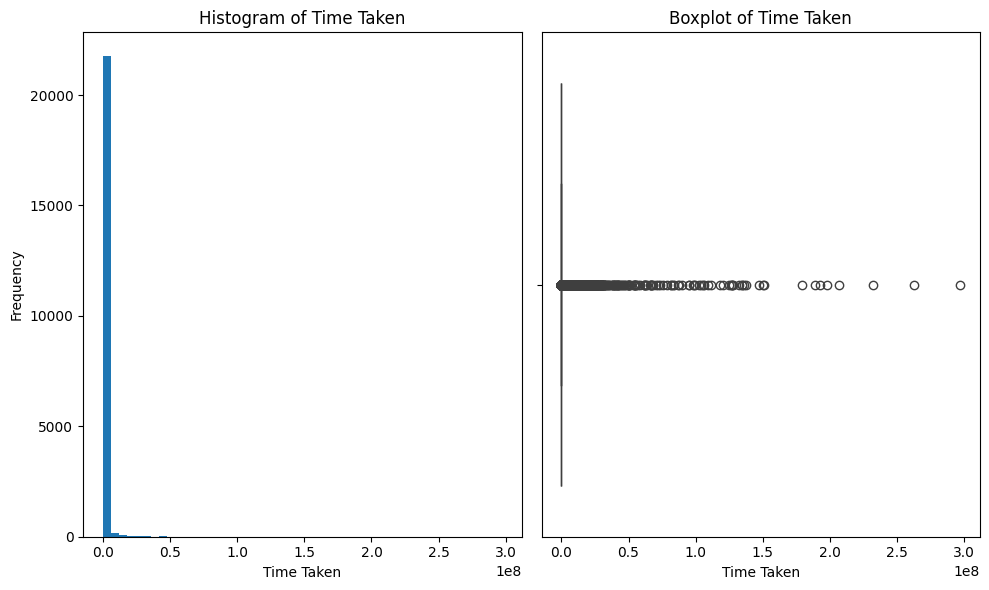

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(df_result['time_taken'], bins=50)
plt.title('Histogram of Time Taken')
plt.xlabel('Time Taken')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(x=df_result['time_taken'])
plt.title('Boxplot of Time Taken')
plt.xlabel('Time Taken')

plt.tight_layout()
plt.show()

# plots for new data after cleaning. 
# This is relevant data as the segments left in this dataset are not too large and not too small.

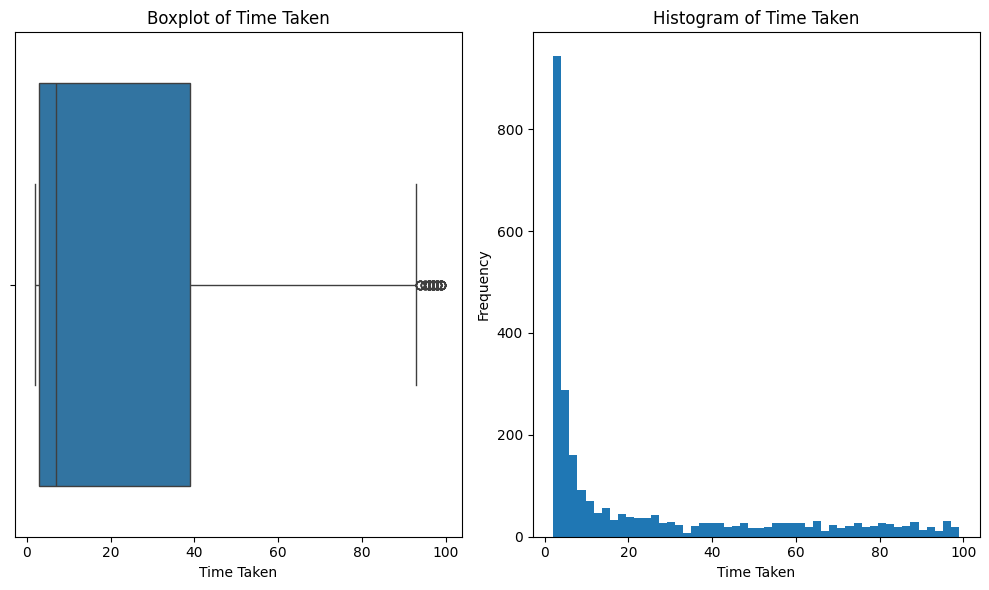

In [26]:
df_result = df_result[df_result['time_taken'] >1]
df_result = df_result[df_result['time_taken'] <100]
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x=df_result['time_taken'])
plt.title('Boxplot of Time Taken')
plt.xlabel('Time Taken')

plt.subplot(1, 2, 2)
plt.hist(df_result['time_taken'], bins=50)
plt.title('Histogram of Time Taken')
plt.xlabel('Time Taken')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

removing outliers, just to be sure.

In [27]:
# Removing outliers based on time taken (you can customize the threshold)
# Here we are using the Interquartile Range (IQR) method to remove outliers
Q1 = df_result['time_taken'].quantile(0.25)
Q3 = df_result['time_taken'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers as any points outside 1.5*IQR from the Q1 and Q3
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df_cleaned = df_result[(df_result['time_taken'] >= lower_bound) & (df_result['time_taken'] <= upper_bound)]



# drop user feature
df_cleaned.drop('user', axis=1, inplace=True)


# Save the cleaned DataFrame to a CSV file
df_cleaned.to_csv('cleaned_eta_prediction_data.csv', index=False)
# df_cleaned.drop('user', axis=1, inplace=True)
print("Dataset has been created, cleaned, and saved successfully.")

Dataset has been created, cleaned, and saved successfully.


C:\Users\harjo\AppData\Local\Temp\ipykernel_2440\1261102753.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.drop('user', axis=1, inplace=True)


# Using KNN.
# We break down our path into small segments, and for those individual segments we predict the ETA
# The final ETA is the summation of the individual ETA of the segments.
# Normalize co-ordinates as the inital few numbers are same for most points in the dataset
# BUT this does not make sure that the segments we interpolated are real roads in real- life.

Estimated Time of Arrival (ETA) between the two locations: 16.900000000000002 minutess


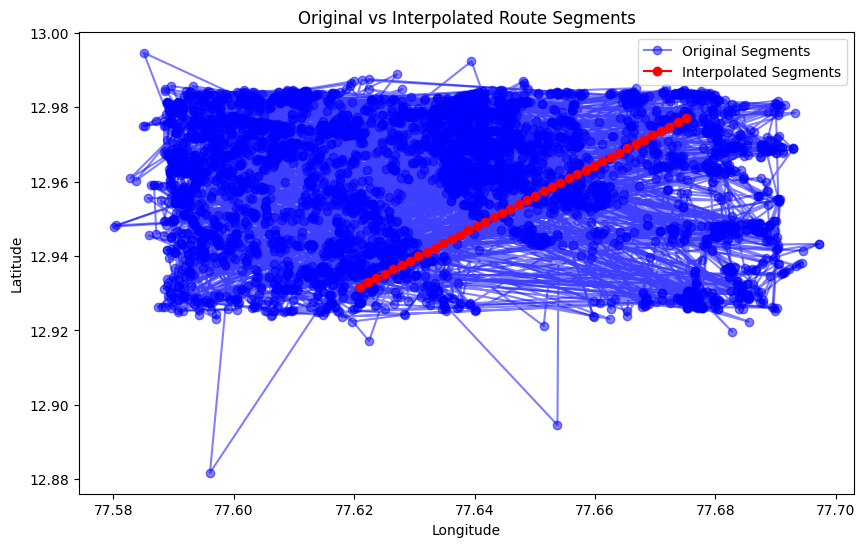

In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from geopy.distance import geodesic
import matplotlib.pyplot as plt
df = pd.read_csv('cleaned_eta_prediction_data.csv')

X = df[['initial_lat', 'initial_lon', 'final_lat', 'final_lon']]
y = df['time_taken']

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_normalized, y)

def calculate_segments(start, end, segment_length_km=0.5):
    total_distance_km = geodesic(start, end).kilometers
    num_segments = int(np.ceil(total_distance_km / segment_length_km))
    return num_segments

def interpolate_segments(start, end, num_segments):
    lats = np.linspace(start[0], end[0], num_segments + 1)
    lons = np.linspace(start[1], end[1], num_segments + 1)
    return list(zip(lats, lons))

start_location = (12.9317652, 77.6209215) 
end_location = (12.9771376, 77.6751392)   

# Calculate the number of segments
num_segments = calculate_segments(start_location, end_location, segment_length_km=0.2) 

# Interpolate to create the segment points
segment_points = interpolate_segments(start_location, end_location, num_segments)


total_eta = 0
for i in range(len(segment_points) - 1):
    segment_start = segment_points[i]
    segment_end = segment_points[i + 1]
    
    segment_df = pd.DataFrame([[segment_start[0], segment_start[1], segment_end[0], segment_end[1]]],
                              columns=['initial_lat', 'initial_lon', 'final_lat', 'final_lon'])
    
 
    segment_normalized = scaler.transform(segment_df)
    predicted_eta = knn.predict(segment_normalized)[0]
    total_eta += predicted_eta

print(f"Estimated Time of Arrival (ETA) between the two locations: {total_eta/60} minutess")

# Plotting the segments
plt.figure(figsize=(10, 6))

# Plot the original segments
plt.plot(df['initial_lon'], df['initial_lat'], 'bo-', alpha=0.5, label='Original Segments')
plt.plot(df['final_lon'], df['final_lat'], 'bo-', alpha=0.5)

# Plot the interpolated segments
lats, lons = zip(*segment_points)
plt.plot(lons, lats, 'ro-', label='Interpolated Segments')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Original vs Interpolated Route Segments')
plt.legend()
plt.show()


# To make sure that the segments are real roads, we use the OSM api and chose driving roads.


Estimated Time of Arrival (ETA) between the two locations: 143.26666666666668 minutes


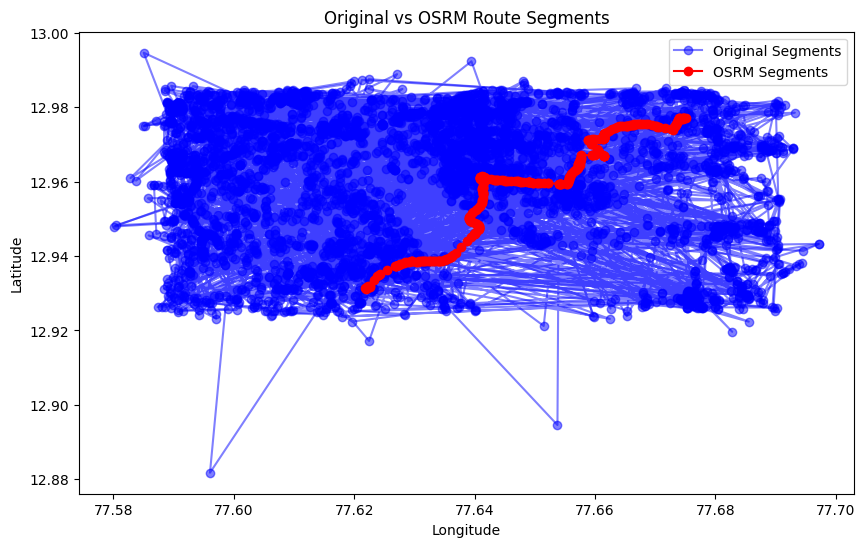

In [32]:
import requests
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

osrm_url = "http://router.project-osrm.org/route/v1/driving/{},{};{},{}?overview=full&geometries=geojson"

start_location = (12.9317652, 77.6209215) 
end_location = (12.9771376, 77.6751392) 

# Query the OSRM API to get the route
route_url = osrm_url.format(start_location[1], start_location[0], end_location[1], end_location[0])
response = requests.get(route_url)
route_data = response.json()

# Extract the coordinates from the route
coordinates = route_data['routes'][0]['geometry']['coordinates']
segment_points = [(coord[1], coord[0]) for coord in coordinates]


df = pd.read_csv('cleaned_eta_prediction_data.csv')

X = df[['initial_lat', 'initial_lon', 'final_lat', 'final_lon']]
y = df['time_taken']

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

knn = KNeighborsRegressor(n_neighbors=1)
knn.fit(X_normalized, y)


total_eta = 0
for i in range(len(segment_points) - 1):
    segment_start = segment_points[i]
    segment_end = segment_points[i + 1]
    
    # Create a DataFrame for the current segment
    segment_df = pd.DataFrame([[segment_start[0], segment_start[1], segment_end[0], segment_end[1]]],
                              columns=['initial_lat', 'initial_lon', 'final_lat', 'final_lon'])
    
    # Normalize the segment
    segment_normalized = scaler.transform(segment_df)
    
    # Predict the ETA for this segment
    predicted_eta = knn.predict(segment_normalized)[0]
    total_eta += predicted_eta


print(f"Estimated Time of Arrival (ETA) between the two locations: {total_eta/60} minutes")

plt.figure(figsize=(10, 6))

plt.plot(df['initial_lon'], df['initial_lat'], 'bo-', alpha=0.5, label='Original Segments')
plt.plot(df['final_lon'], df['final_lat'], 'bo-', alpha=0.5)

lats, lons = zip(*segment_points)
plt.plot(lons, lats, 'ro-', label='OSRM Segments')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Original vs OSRM Route Segments')
plt.legend()
plt.show()



# But still, the length of the original segment and interpolated segment might be different. We need to fix this.

Estimated Time of Arrival (ETA) between the two locations: 7.01 minutes


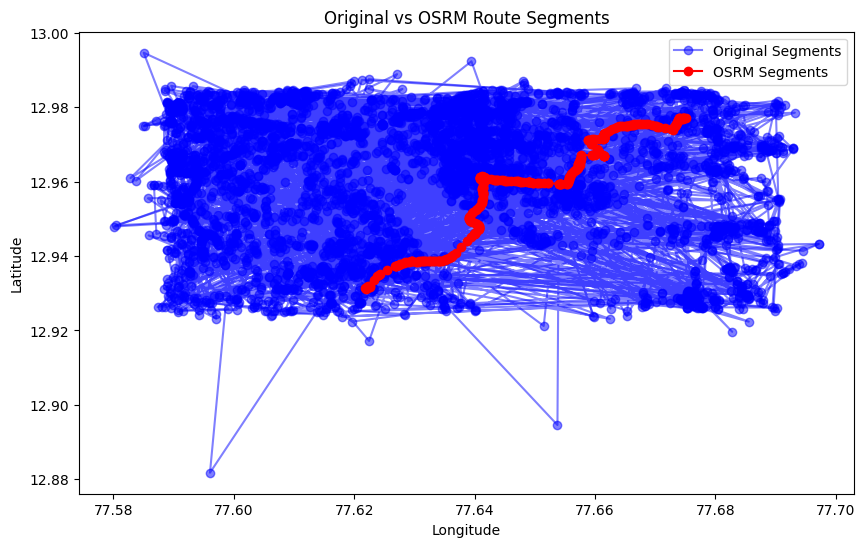

In [33]:
import requests
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
from geopy.distance import great_circle

osrm_url = "http://router.project-osrm.org/route/v1/driving/{},{};{},{}?overview=full&geometries=geojson"

start_location = (12.9317652, 77.6209215) 
end_location = (12.9771376, 77.6751392) 

route_url = osrm_url.format(start_location[1], start_location[0], end_location[1], end_location[0])
response = requests.get(route_url)
route_data = response.json()

coordinates = route_data['routes'][0]['geometry']['coordinates']
segment_points = [(coord[1], coord[0]) for coord in coordinates]

df = pd.read_csv('cleaned_eta_prediction_data.csv')

def calculate_segment_length(start, end):
    return great_circle(start, end).meters

df['segment_length'] = df.apply(lambda row: calculate_segment_length((row['initial_lat'], row['initial_lon']), 
                                                                     (row['final_lat'], row['final_lon'])), axis=1)

X = df[['initial_lat', 'initial_lon', 'final_lat', 'final_lon', 'segment_length']]
y = df['time_taken']

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

knn = KNeighborsRegressor(n_neighbors=1)
knn.fit(X_normalized, y)

average_segment_length = df['segment_length'].mean()

total_eta = 0
for i in range(len(segment_points) - 1):
    segment_start = segment_points[i]
    segment_end = segment_points[i + 1]
    
    segment_length = calculate_segment_length(segment_start, segment_end)

    segment_df = pd.DataFrame([[segment_start[0], segment_start[1], segment_end[0], segment_end[1], segment_length]],
                              columns=['initial_lat', 'initial_lon', 'final_lat', 'final_lon', 'segment_length'])
    
    segment_normalized = scaler.transform(segment_df)

    predicted_eta = knn.predict(segment_normalized)[0]

    adjusted_eta = predicted_eta * (segment_length / average_segment_length)
    total_eta += adjusted_eta

print(f"Estimated Time of Arrival (ETA) between the two locations: {total_eta/60:.2f} minutes")

plt.figure(figsize=(10, 6))

plt.plot(df['initial_lon'], df['initial_lat'], 'bo-', alpha=0.5, label='Original Segments')
plt.plot(df['final_lon'], df['final_lat'], 'bo-', alpha=0.5)

lats, lons = zip(*segment_points)
plt.plot(lons, lats, 'ro-', label='OSRM Segments')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Original vs OSRM Route Segments')
plt.legend()
plt.show()


# For real time updates, I simply added a loop.<br>
# To get real time user location, ipstack API was used.<br>
# The api key is hard coded for testing purposes for the assignment.


Current Location: (28.621299743652344, 77.21029663085938)
Updated ETA from current location ((28.621299743652344, 77.21029663085938)) to destination: 628.46 minutes


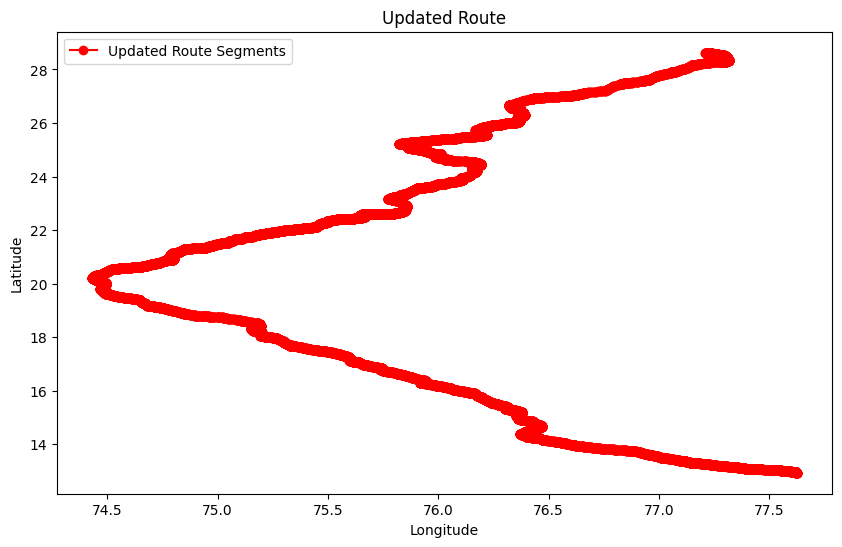

In [34]:
import requests
import pandas as pd
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
from geopy.distance import geodesic

osrm_url = "http://router.project-osrm.org/route/v1/driving/{},{};{},{}?overview=full&geometries=geojson"

end_location = (12.9371376, 77.6241392)  

df = pd.read_csv('cleaned_eta_prediction_data.csv')

def calculate_segment_length(start, end):
    return geodesic(start, end).meters

df['segment_length'] = df.apply(lambda row: calculate_segment_length((row['initial_lat'], row['initial_lon']), 
                                                                     (row['final_lat'], row['final_lon'])), axis=1)

X = df[['initial_lat', 'initial_lon', 'final_lat', 'final_lon', 'segment_length']]
y = df['time_taken']

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_normalized, y)

average_segment_length = df['segment_length'].mean()

def get_current_location():
    access_key = '080ef27648be7d96af0413697f6b4b53'
    response = requests.get(f'http://api.ipstack.com/check?access_key={access_key}')
    
    if response.status_code == 200:
        data = response.json()
        return data['latitude'], data['longitude']
    else:
        raise Exception("Error fetching location data")

current_location = get_current_location()
print(f"Current Location: {current_location}")

def calculate_eta_from_current_location(current_location):
    route_url = osrm_url.format(current_location[1], current_location[0], end_location[1], end_location[0])
    response = requests.get(route_url)
    route_data = response.json()
    
    coordinates = route_data['routes'][0]['geometry']['coordinates']
    segment_points = [(coord[1], coord[0]) for coord in coordinates]

    total_eta = 0
    for i in range(len(segment_points) - 1):
        segment_start = segment_points[i]
        segment_end = segment_points[i + 1]

        segment_length = calculate_segment_length(segment_start, segment_end)

        segment_df = pd.DataFrame([[segment_start[0], segment_start[1], segment_end[0], segment_end[1], segment_length]],
                                  columns=['initial_lat', 'initial_lon', 'final_lat', 'final_lon', 'segment_length'])

        segment_normalized = scaler.transform(segment_df)

        predicted_eta = knn.predict(segment_normalized)[0]

        adjusted_eta = predicted_eta * (segment_length / average_segment_length)
        total_eta += adjusted_eta
    
    return total_eta, segment_points

while True:
    current_location = get_current_location()
    
    eta, segment_points = calculate_eta_from_current_location(current_location)
    
    print(f"Updated ETA from current location ({current_location}) to destination: {eta/60:.2f} minutes")
    
    plt.figure(figsize=(10, 6))
    lats, lons = zip(*segment_points)
    plt.plot(lons, lats, 'ro-', label='Updated Route Segments')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Updated Route')
    plt.legend()
    plt.show()
    
    if geodesic(current_location, end_location).meters < 10:
        print("Destination reached.")
        break
    
    time.sleep(10)
    
    current_location = (current_location[0] + 0.0001, current_location[1] + 0.0001)

